Tulashie SK, Kaemmerer H, Lorenz H, Seidel-Morgenstern A. Solid− liquid equilibria of mandelic acid enantiomers in two chiral solvents: experimental determination and model correlation. Journal of Chemical & Engineering Data. 2010 Jan 14;55(1):333-40.

# Solubility Curve

Once SolMod is installed, it can be loaded using:

In [2]:
using SolMod

We import our parameters from .xlsx files that contain the dataframe necessary to produce a solubility calculation. This format is used to exploit the use of sheets as the parameters for different solvents. The first sheet contains the calorimetric data of the enantiomeric molecule and the racemate:

| fusΔH |  Tm  | fusΔH_rac | Tm_rac |
| :---: | :--: | :-------: | :----: |
| 24,500|404.65|     25,600|  387.75|

The data frame is imported as a dictionary to the workspace. When specifying parameters of 3 components, the function will automatically import the calorimetric properties of the racemate as well:

In [3]:
dir = pathof(SolMod)[1:end-13]*"examples/Database/Tulashie_Parameters.xlsx"

params = NRTL_importParameters(dir, 3)

Dict{Any, Any} with 2 entries:
  "Solute"           => Any[24500 404.65 25600 387.75]
  "Diethyl Tartrate" => Dict{Any, Any}("g"=>Any[0 216631 25269; 141879 0 25269;…

In [5]:
params["Solute"]

1×4 Matrix{Any}:
 24500  404.65  25600  387.75

The parameters specify the interaction values determined from either experimental or predicted values. Interaction parameters are model specific, in this case we will use those defined by the NRTL model:

|⍺_1|⍺_2|⍺_3|g_1|g_2|g_3|
|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.98|0.40|0|216,631|25,269|
|0.98|0|0|0.40|141,879|0|25,269|
|0.40|0.40|0|-3,235.60|-3,235.60|0|

The dataframe is imported as a dictionary with the key entry labelled as the solvent used:

In [6]:
params["Diethyl Tartrate"]["⍺"]

3×3 Matrix{Any}:
 0         0.979748  0.40104
 0.979748  0         0.40104
 0.40104   0.40104   0

In [7]:
params["Diethyl Tartrate"]["g"]

3×3 Matrix{Any}:
      0    216631    25269
 141879         0    25269
  -3235.6   -3235.6      0

With the parameters imported, we can use the model to determine the activity coefficient. We want to predict a solubility curve for the S-enantiomer. The curve will range from  ``298 K``  to  ``334 K``  and an initial guess of the composition:

In [8]:
model = NRTL_solubilityCurve(params, [298, 334], "Diethyl Tartrate", guess = 0.12, components = 3)

37×2 Matrix{Any}:
 298  0.127801
 299  0.131493
 300  0.135265
 301  0.139118
 302  0.143054
 303  0.147072
 304  0.151175
 305  0.155363
 306  0.159637
 307  0.163999
   ⋮  
 326  0.264941
 327  0.27128
 328  0.27773
 329  0.284291
 330  0.290965
 331  0.297752
 332  0.304654
 333  0.311672
 334  0.318806

We can also obtain an error analysis using SolMod. We will get an output of the residuals from the experimental data and the RMSD (Root Mean Square Deviation). The RMSD of predicted values  $\hat{x}$  for times a with variables observed over  $A$  times, is computed for  $A$  different predictions as the square root of the mean of the squares of the deviations:

$$
RMSD = \sqrt{\dfrac{\sum_{a=1}^A{(\hat{x}_a - x_a)^2}}{|A|}}
$$

We first create the dataframe of our experimental data in the format:

| Temperature (K) | Molar Fraction |
| :-------------: | :------------: |
| $T_1$ | $x_1$ |
| $T_2$ | $x_2$ |
| ... | ... |

In [9]:
Exp = [298.15 0.1334
       308.15 0.1703
       318.15 0.2 
       323.15 0.2287
       328.15 0.2415
       333.15 0.2607]

6×2 Matrix{Float64}:
 298.15  0.1334
 308.15  0.1703
 318.15  0.2
 323.15  0.2287
 328.15  0.2415
 333.15  0.2607

The function errorAnalysis will output the RMSD in the console and a dataframe with the residuals at that experimental point as the third column will be produced as a result:

In [10]:
errorAnalysis(model, Exp, 2)


RMSD: 0.19097621794183633



6×3 Matrix{Any}:
 298.15  0.1334  0.00559905
 308.15  0.1703  0.042499
 318.15  0.2     0.072199
 323.15  0.2287  0.100899
 328.15  0.2415  0.113699
 333.15  0.2607  0.132899

Using the Julia native package [Plots](https://github.com/JuliaPlots/Plots.jl) we can plot the predicted curve for our system with the experimental points.

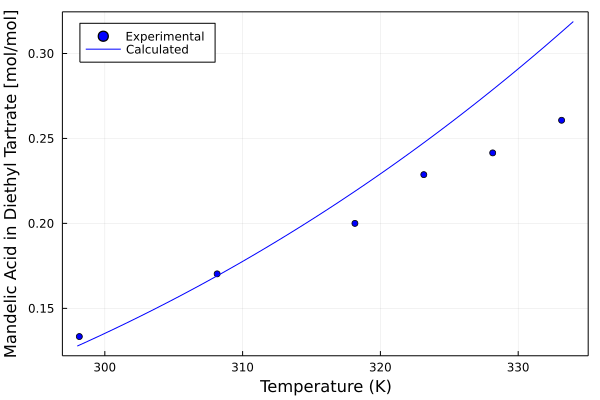

In [11]:
using Plots

scatter(Exp[1:end, 1], Exp[1:end, 2], markercolor = "blue", label = "Experimental")
plot!(model[1:end, 1], model[1:end, 2], color = "blue", label = "Calculated", legend=:topleft)
plot!(xlabel = "Temperature (K)", ylabel = "Mandelic Acid in Diethyl Tartrate [mol/mol]", framestyle = :box)

# Ternary Phase Diagram

We want to start by defining the method we will use to calculate the activity coefficient for component **i** (S-enantiomer) and for component **j** (R-enantiomer). For example calculating the activity coefficient using the NRTL model at  ``328.15 K`` :

In [12]:
γi() = NRTL_activityCoefficient(params, "Diethyl Tartrate", 328.15)
γj() = NRTL_activityCoefficient(params, "Diethyl Tartrate", 328.15, e = false)

γj (generic function with 1 method)

Once the activity coefficient methods are set, we want to check solubility over every possible point at a specific temperature using the ternaryPhase function. The ternary phase function will output the eutectic points at the specified temperature and the values of the enantiomeric excess from both eutectic points:

In [13]:
model = ternaryPhase(params, γi, γj, 328.15)

Eutectic points of isotherm 328.15K are at composition: 

x1: 0.112 x2: 0.283 x3: 0.605
x1: 0.285 x2: 0.112 x3: 0.603

Enantiomeric Excess = 

Eutectic 1: xi 71.65% - xj 28.35%

Eutectic 2: xi 28.21% - xj 71.79%



4246×3 Matrix{Float64}:
 0.001  0.273  0.726
 0.001  0.274  0.725
 0.001  0.275  0.724
 0.001  0.276  0.723
 0.001  0.277  0.722
 0.001  0.278  0.721
 0.001  0.279  0.72
 0.001  0.28   0.719
 0.001  0.281  0.718
 0.001  0.282  0.717
 ⋮             
 0.277  0.116  0.607
 0.277  0.117  0.606
 0.278  0.114  0.608
 0.278  0.115  0.607
 0.278  0.116  0.606
 0.279  0.114  0.607
 0.279  0.115  0.606
 0.28   0.114  0.606
 0.281  0.113  0.606

After importing the experimental data for the solubility of the ternary phase system, we can obtain the error analysis related to the ternary phase diagram with the same function as before but increasing the number of components to 3:

In [14]:
dir = pathof(SolMod)[1:end-13]*"examples/Database/Tulashie_Experimental.xlsx"

Exp = importExperimentalTernaryPhase(dir)

errorAnalysis(model, Exp["328.15"]./100, 3)


RMSD: 0.03623672531255591



5×4 Matrix{Any}:
 0.2415  0.0     0.7585  0.0452714
 0.2528  0.1136  0.6336  0.0169988
 0.1096  0.2499  0.6405  0.0246783
 0.1586  0.158   0.6834  0.0482568
 0.0     0.241   0.759   0.0459783

We can then natively plot the ternary phase diagram in Julia using [TernaryPlots](https://github.com/jacobusmmsmit/TernaryPlots.jl) (Although this package requires a considerable setup, it is currently one of the few available plotting methods available. Check Plotly or Matplotlib using Python as an alternative)

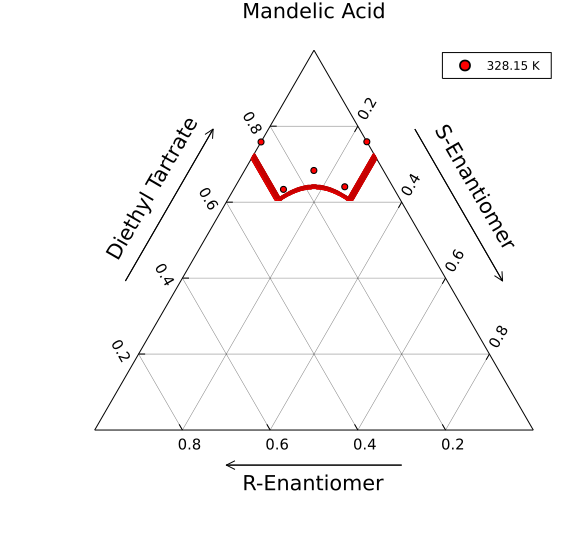

In [16]:
using TernaryPlots

a = [zeros(eltype(model), size(model, 1)) zeros(eltype(model), size(model, 1))]
for i in 1:size(model,1) a[i,:] = collect(tern2cart(model[i,:]))' end
xa = [zeros(eltype(Exp["328.15"]), size(Exp["328.15"], 1)) zeros(eltype(Exp["328.15"]), size(Exp["328.15"], 1))]
for i in 1:size(Exp["328.15"],1) xa[i,:] = collect(tern2cart(Exp["328.15"][i,:]))' end

ternary_axes(
    title="Mandelic Acid",
    xguide="R-Enantiomer",
    yguide="S-Enantiomer",
    zguide="Diethyl Tartrate",
)


p = scatter!(a[:,1],a[:,2], markerstrokewidth=0, label = false,
markercolor = "red", markersize = 2)

p = scatter!(xa[:,1],xa[:,2], markerstrokewidth=1,markercolor = "red", markersize = 4, 
label = "328.15 K", markershape =:circle)

We can then repeat this process across multiple temperatures:

In [33]:
t = [298.15, 308.15, 318.15, 323.15, 328.15, 333.15]

model = Dict()

for i in t

    γi() = NRTL_activityCoefficient(params, "Diethyl Tartrate", i)
    γj() = NRTL_activityCoefficient(params, "Diethyl Tartrate", i, e = false)
    model[i] = ternaryPhase(params, γi, γj, i)

end

Eutectic points of isotherm 298.15K are at composition: 

x1: 0.048 x2: 0.129 x3: 0.823
x1: 0.131 x2: 0.048 x3: 0.821

Enantiomeric Excess = 

Eutectic 1: xi 72.88% - xj 27.12%

Eutectic 2: xi 26.82% - xj 73.18%

Eutectic points of isotherm 308.15K are at composition: 

x1: 0.065 x2: 0.171 x3: 0.764
x1: 0.172 x2: 0.065 x3: 0.763

Enantiomeric Excess = 

Eutectic 1: xi 72.46% - xj 27.54%

Eutectic 2: xi 27.43% - xj 72.57%

Eutectic points of isotherm 318.15K are at composition: 

x1: 0.086 x2: 0.222 x3: 0.692
x1: 0.223 x2: 0.086 x3: 0.691

Enantiomeric Excess = 

Eutectic 1: xi 72.08% - xj 27.92%

Eutectic 2: xi 27.83% - xj 72.17%

Eutectic points of isotherm 323.15K are at composition: 

x1: 0.098 x2: 0.252 x3: 0.65
x1: 0.253 x2: 0.098 x3: 0.649

Enantiomeric Excess = 

Eutectic 1: xi 72.0% - xj 28.0%

Eutectic 2: xi 27.92% - xj 72.08%

Eutectic points of isotherm 328.15K are at composition: 

x1: 0.112 x2: 0.283 x3: 0.605
x1: 0.285 x2: 0.112 x3: 0.603

Enantiomeric Excess = 

Eutectic

And plot them all in one figure:

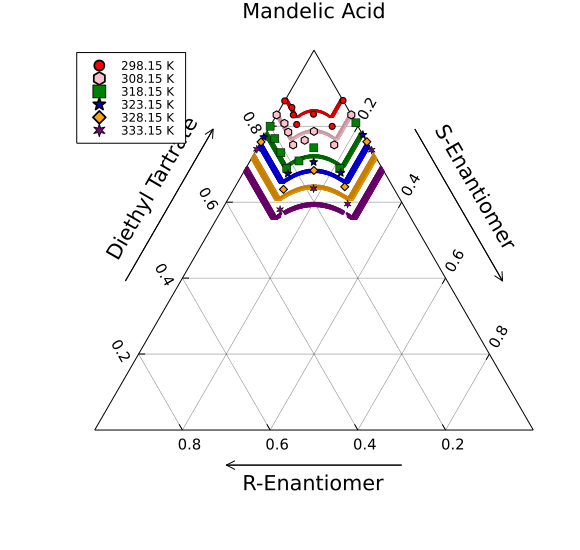

In [34]:

for j in range(1, length(collect(keys(model))))

    model[t[j]] = 100 .* model[t[j]]
    model[t[j]][1:end, 1], model[t[j]][1:end, 2] = model[t[j]][1:end, 2], model[t[j]][1:end, 1]

end

a = [zeros(eltype(model[t[1]]), size(model[t[1]], 1)) zeros(eltype(model[t[1]]), size(model[t[1]], 1))]
b = [zeros(eltype(model[t[2]]), size(model[t[2]], 1)) zeros(eltype(model[t[2]]), size(model[t[2]], 1))]
c = [zeros(eltype(model[t[3]]), size(model[t[3]], 1)) zeros(eltype(model[t[3]]), size(model[t[3]], 1))]
d = [zeros(eltype(model[t[4]]), size(model[t[4]], 1)) zeros(eltype(model[t[4]]), size(model[t[4]], 1))]
e = [zeros(eltype(model[t[5]]), size(model[t[5]], 1)) zeros(eltype(model[t[5]]), size(model[t[5]], 1))]
f = [zeros(eltype(model[t[6]]), size(model[t[6]], 1)) zeros(eltype(model[t[6]]), size(model[t[6]], 1))]

for i in 1:size(model[t[1]],1) a[i,:] = collect(tern2cart(model[t[1]][i,:]))' end
for i in 1:size(model[t[2]],1) b[i,:] = collect(tern2cart(model[t[2]][i,:]))' end
for i in 1:size(model[t[3]],1) c[i,:] = collect(tern2cart(model[t[3]][i,:]))' end
for i in 1:size(model[t[4]],1) d[i,:] = collect(tern2cart(model[t[4]][i,:]))' end
for i in 1:size(model[t[5]],1) e[i,:] = collect(tern2cart(model[t[5]][i,:]))' end
for i in 1:size(model[t[6]],1) f[i,:] = collect(tern2cart(model[t[6]][i,:]))' end

xa = [zeros(eltype(Exp["298.15"]), size(Exp["298.15"], 1)) zeros(eltype(Exp["298.15"]), size(Exp["298.15"], 1))]
xb = [zeros(eltype(Exp["308.15"]), size(Exp["308.15"], 1)) zeros(eltype(Exp["308.15"]), size(Exp["308.15"], 1))]
xc = [zeros(eltype(Exp["318.15"]), size(Exp["318.15"], 1)) zeros(eltype(Exp["318.15"]), size(Exp["318.15"], 1))]
xd = [zeros(eltype(Exp["323.15"]), size(Exp["323.15"], 1)) zeros(eltype(Exp["323.15"]), size(Exp["323.15"], 1))]
xe = [zeros(eltype(Exp["328.15"]), size(Exp["328.15"], 1)) zeros(eltype(Exp["328.15"]), size(Exp["328.15"], 1))]
xf = [zeros(eltype(Exp["333.15"]), size(Exp["333.15"], 1)) zeros(eltype(Exp["333.15"]), size(Exp["333.15"], 1))]

for i in 1:size(Exp["298.15"],1) xa[i,:] = collect(tern2cart(Exp["298.15"][i,:]))' end
for i in 1:size(Exp["308.15"],1) xb[i,:] = collect(tern2cart(Exp["308.15"][i,:]))' end
for i in 1:size(Exp["318.15"],1) xc[i,:] = collect(tern2cart(Exp["318.15"][i,:]))' end
for i in 1:size(Exp["323.15"],1) xd[i,:] = collect(tern2cart(Exp["323.15"][i,:]))' end
for i in 1:size(Exp["328.15"],1) xe[i,:] = collect(tern2cart(Exp["328.15"][i,:]))' end
for i in 1:size(Exp["333.15"],1) xf[i,:] = collect(tern2cart(Exp["333.15"][i,:]))' end

ternary_axes(
    title="Mandelic Acid",
    xguide="R-Enantiomer",
    yguide="S-Enantiomer",
    zguide="Diethyl Tartrate",
)

p = scatter!(a[:,1],a[:,2], markerstrokewidth=0, label = false,
markercolor = "red", markersize = 2)
p = scatter!(b[:,1],b[:,2], markerstrokewidth=0, label = false,
markercolor = "pink", markersize = 2)
p = scatter!(c[:,1],c[:,2], markerstrokewidth=0, label = false,
markercolor = "green", markersize = 2)
p = scatter!(d[:,1],d[:,2], markerstrokewidth=0, label = false,
markercolor = "blue", markersize = 2)
p = scatter!(e[:,1],e[:,2], markerstrokewidth=0, label = false,
markercolor = "orange", markersize = 2)
p = scatter!(f[:,1],f[:,2], markerstrokewidth=0, label = false,
markercolor = "purple", markersize = 2)
p = scatter!(xa[:,1],xa[:,2], markerstrokewidth=1,markercolor = "red", markersize = 4, 
label = "298.15 K", markershape =:circle)
p = scatter!(xb[:,1],xb[:,2], markerstrokewidth=1,markercolor = "pink", markersize = 4, 
label = "308.15 K", markershape =:hexagon)
p = scatter!(xc[:,1],xc[:,2], markerstrokewidth=0.5,markercolor = "green", markersize = 4, 
label = "318.15 K", markershape =:rect)
p = scatter!(xd[:,1],xd[:,2], markerstrokewidth=1,markercolor = "blue", markersize = 4, 
label = "323.15 K", markershape =:star5)
p = scatter!(xe[:,1],xe[:,2], markerstrokewidth=1,markercolor = "orange", markersize = 4, 
label = "328.15 K", markershape =:diamond)
p = scatter!(xf[:,1],xf[:,2], markerstrokewidth=0.5,markercolor = "purple", markersize = 4, 
label = "333.15 K", legend =:topleft, markershape =:star6)